# Frequency Response Function Demo

In [1]:
import sys
import math
import numpy as np
import numexpr as ne
sys.path.append("../affect")
import exodus

Our Exodus input file, field variable names, and mesh nodes we are interested in (we use zero based nodes ID's).

In [2]:
path = './SRS-FRF-example/model/1/p1f-out.h'
input_variable = 'AForceZ'
output_variable = 'AccZ'
input_node = 1
output_node = 0

Open Exodus and read fields for all times

In [3]:
with exodus.DatabaseFile(path) as e:
    times = e.globals.times()
    num_times = times.size
    names = e.nodal.variable_names()
    input_id = names.index(input_variable)
    output_id = names.index(output_variable)
    output_array = e.nodal.variable_at_times(output_id, output_node, 0, num_times)
    input_array = e.nodal.variable_at_times(input_id, input_node, 0, num_times)

Compute timestep $\Delta t$, and $\Delta f = \dfrac{1}{n_{time} \Delta t}$

In [4]:
dt = times[1] - times[0]
df = 1.0 / (float(num_times) * dt)

Get $n_{time/2} = \lfloor{\dfrac{n_{time}}{2}}\rfloor$, and $f_i = \{0,\;\Delta f,\;2\Delta f,\;3\Delta f,\;...,\; n_{time/2}\Delta f\}$

In [5]:
num_times_2 = int(math.floor(num_times / 2))
f = np.linspace(0.0, float(num_times_2)*df, num_times_2+1)

Compute the two fast fourier transforms of the fields, and the frequency response function 

In [6]:
h_output = np.fft.fft(output_array)[0:num_times_2+1] * dt
h_input = np.fft.fft(input_array)[0:num_times_2+1] * dt
frf = ne.evaluate("where(h_input != 0, real(abs(h_output / h_input)), 0.0)")

## Plot the FRF

Compute the peaks and show an interactive chart

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.MatplotlibDeprecationWarning)
import mpld3
mpld3.enable_notebook(local=True)
from scipy.signal import argrelmax
peaks = argrelmax(frf, order=2)
fig, ax = plt.subplots(figsize=(8,5))
ax.yaxis.set_scale('log')  # deprecation warning
f_max = math.ceil(f[-1] / 1000.) * 1000.  # round to the nearest thousand
ax.set_xlim(xmin=0.0,xmax=f_max)
ax.plot(f, frf, lw=2)
points = ax.scatter(f.take(peaks[0]), frf.take(peaks[0]), s=50, color='blue', alpha=0.3)
labels = ['freq {:.2f}'.format(y) for y in f.take(peaks[0])]
tooltip = mpld3.plugins.PointLabelTooltip(points, labels)#
mpld3.plugins.connect(fig, tooltip)

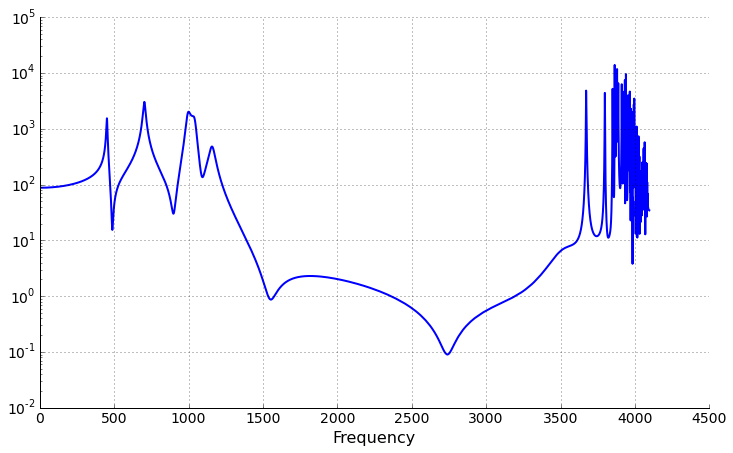

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import argrelmax
peaks = argrelmax(frf, order=2)
fig, ax = plt.subplots(figsize=(12,7))
ax.semilogy(f, frf, lw=2)
plt.grid(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Frequency", fontsize=16)
plt.show()